## Libraries

In [1]:
import os

In [2]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [3]:
import sys
sys.path.append('..')
from src.grass_functions import*
from src.data.process_inputs import*
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Parameters

In [4]:
#set project variables
Project_Area = 'cassia_minidoka'
GRASS_GIS_Projection = projection = '6449' #set to None if you want to use the DEM's original projection
res = '2m'

threshold = 27878400 #sq feet == 1 sq mi

## Set variables analysis
data_scale = 'Name' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '*' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = pl.Path(os.getcwd()).parent/'data'/'Vectors'/Project_Area/'Model_Basin_Delineations.shp' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 3000 #units of projection
auto_delete = False
dem = 'project_dem'
aligned = False
export = False

In [5]:
stream_source_nhd = False
stream_shp = 'hydro_conn_combined.shp'

In [6]:
## Paths:
parent_dir = pl.Path(os.getcwd()).parent/'data'
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
huc_path = vector_dir/'{}_aoi.geojson'.format(Project_Area)
git_data_repo = current_dir/'data_repository'
if input_shp_name:
    input_shp = git_data_repo/input_shp_name
directory = outputs_dir

### Get area of interest

In [7]:
#read from to vector path from notebook 1
huc_path = vector_dir/'{0}_aoi.geojson'.format(Project_Area)
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")

In [8]:
aoi

,Id,Area,Name,pop,geometry
0,0,239.800747,Raft_River_1,NaN,"POLYGON ((1813360.372 362846.674, 1816763.150 ..."
1,0,217.640200,Goose_Creek_3,NaN,"POLYGON ((1586995.551 17675.605, 1586846.440 1..."
2,0,223.089125,Goose_Creek_2,NaN,"POLYGON ((1677001.724 81916.581, 1676729.905 8..."
3,0,292.749471,Goose_Creek_1,NaN,"POLYGON ((1664566.349 195952.039, 1664583.277 ..."
4,0,229.680895,Raft_River_6,NaN,"POLYGON ((1690490.345 152669.980, 1690735.670 ..."
5,0,308.054494,Raft_River_4,NaN,"POLYGON ((1860847.008 193103.877, 1860877.325 ..."
6,0,636.328323,Snake_River_South_FP,1.0,"POLYGON ((1638078.101 232681.533, 1638389.423 ..."
7,0,292.634941,Snake_River_Southwest_FP,NaN,"POLYGON ((1640357.913 311014.064, 1640362.816 ..."
8,0,175.980311,Raft_River_5,NaN,"POLYGON ((1781312.711 99590.448, 1781403.063 9..."
9,0,374.915350,Raft_River_3,NaN,"POLYGON ((1820249.117 256969.847, 1821053.805 ..."


### Start new grass session

In [9]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [10]:
raster_dir

PosixPath('/home/data/Rasters/cassia_minidoka')

In [11]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'cassia_minidoka_6449', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [12]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
aoi@PERMANENT
aoi_Goose_Creek_1@PERMANENT
aoi_Goose_Creek_1_buffer@PERMANENT
aoi_Goose_Creek_2@PERMANENT
aoi_Goose_Creek_2_buffer@PERMANENT
aoi_Goose_Creek_3@PERMANENT
aoi_Goose_Creek_3_buffer@PERMANENT
aoi_Raft_River_1@PERMANENT
aoi_Raft_River_1_buffer@PERMANENT
aoi_Raft_River_2@PERMANENT
aoi_Raft_River_2_buffer@PERMANENT
aoi_Raft_River_3@PERMANENT
aoi_Raft_River_3_buffer@PERMANENT
aoi_Raft_River_4@PERMANENT
aoi_Raft_River_4_buffer@PERMANENT
aoi_Raft_River_5@PERMANENT
aoi_Raft_River_5_buffer@PERMANENT
aoi_Raft_River_6@PERMANENT
aoi_Raft_River_6_buffer@PERMANENT
aoi_Snake_River_North_FP@PERMANENT
aoi_Snake_River_North_FP_buffer@PERMANENT
aoi_Snake_River_South_FP@PERMANENT
aoi_Snake_River_South_FP_buffer@PERMANENT
aoi_Snake_River_Southwest_FP@PERMANENT
aoi_Snake_River_Southwest_FP_buffer@PERMANENT
aoi_buffer@PERMANENT
carve_lines@PERMANENT
carve_lines_Goose_Creek_1@PERMANENT
carve_lines_Goose_Creek_2@PERMANENT
carve_lines_Goose_Creek_3@PERMANENT
carve_lines_Raft_R

In [13]:
#remove old files if needed
remove_grass_data(grass_maps,'None','raster') #all as 

In [14]:
basin_list = aoi[data_scale].to_list()
basins = 'aoi'
assert dem+"@PERMANENT" in grass_maps['raster'], 'Check that dem exists in GRASS'

In [69]:
#add mask and reset project region
gs.run_command('v.buffer',input=basins,output=basins+'_buffer',distance = buffer)

In [34]:
#mask outside cells
gs.run_command('r.mask',vector = basins+'_buffer')
#update dem to include select area name with mask

if aligned:
    dem = f'{dem}_a'

Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   

In [15]:
gs.run_command('r.mask',flags='r')

Raster MASK removed


0

In [16]:
reg = gs.parse_command('g.region',raster = dem, align = dem, zoom=dem,flags='pg')

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


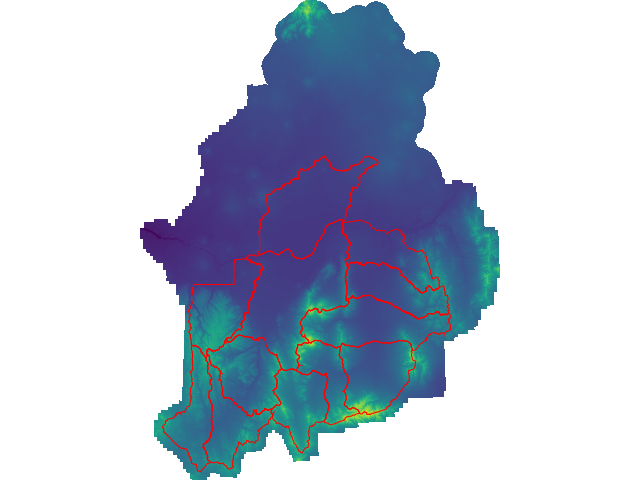

In [17]:
#show mask
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= 'aoi',color='red',fill_color='None')
Image(filename="map.png")

In [18]:
#import related data
gs.run_command('g.region',raster = dem, align = dem, zoom=dem,flags='pg')

projection=99
zone=0
n=683716.8893912
s=-8197.73727547
w=1485773.16548671
e=2005555.5904867
nsres=6.56166667
ewres=6.56166667
rows=105448
cols=79215
cells=8353063320


0

In [19]:
force=False
GRASS_vector_files = [file for line in gs.list_strings(type='vector') for file in [line.split("@")[0]]]
if stream_source_nhd:
    nhd = f'nhd{select_data[:4]}'
    v_stream = f'stream_{select_data}'
    if nhd not in GRASS_vector_files or force:
        gs.run_command('v.import', input=  vector_dir/('NHDPLUS_H_'+select_data[:4]+'_HU4_GDB.gdb'),extent='region', layer = 'NHDFlowline',  output= nhd)

else:
    v_stream = f'carve_lines'
    if v_stream not in GRASS_vector_files or force:
        assert os.path.exists(vector_dir/stream_shp), "stream file is not in vector / project folder"
        assert str(vector_dir/stream_shp)[-4:] != '.gdb', "stream file is gdb but code needs to be updated to accept that filetype"
        gs.run_command('v.import', input=  vector_dir/stream_shp,extent='region',  output= v_stream)

In [20]:
#import sinks and convert to rasters
v_sink = f'sink_points'
r_sink = 'sink_grids'

In [75]:
sinks = gpd.read_file(vector_dir/'Sink_Locations.shp').to_crs(epsg=projection).to_file(vector_dir/f'Sink_Locations_{projection}.shp')
gs.run_command('v.import', input=  vector_dir/f'Sink_Locations_{projection}.shp',extent='region',  output= v_sink)
gs.run_command('v.to.rast', input= v_sink,output = r_sink,type='point',use='val')

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
Check if OGR layer <Sink_Locations_6449> contains polygons...
   0  14  28  42  57  71  85 100
Creating attribute table for layer <Sink_Locations_6449>...
Importing 7 features (OGR layer <Sink_Locations_6449>)...
   0  14  28  42  57  71  85 100
-----------------------------------------------------
Building topology for vector map <sink_points@PERMANENT>...
Registering primitives...
Input </home/data/Vectors/cassia_minidoka/Sink_Locations_6449.shp>
successfully imported without reprojection
Pass 1 of 72:
Reading features...
  14  28  42  57  71  85 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Pass 2 of 72:
Reading features...
  14  28 

0

In [ ]:
##print watershed flowlines @ Regional scale to confirm data and extent
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= basins,color='black',fill_color='none')
#gs.run_command('d.vect', map= v_stream,color='red',fill_color='red',width=10)
Image(filename="map.png")

## Burn Stream Network Into DEM (Full Burn)

In [18]:
reg = gs.parse_command('g.region',raster = dem, align = dem, zoom=dem,flags='pg')

In [21]:
cell_size_ns = float(reg.nsres)
cell_size_ew = float(reg.ewres)

In [22]:
cell_size_ew

6.56166667

In [23]:
areas = aoi.Name.to_list()

In [24]:
areas

['Raft_River_1',
 'Goose_Creek_3',
 'Goose_Creek_2',
 'Goose_Creek_1',
 'Raft_River_6',
 'Raft_River_4',
 'Snake_River_South_FP',
 'Snake_River_Southwest_FP',
 'Raft_River_5',
 'Raft_River_3',
 'Raft_River_2',
 'Snake_River_North_FP']

In [25]:
threshold = 27878400 #sq feet == 1 sq mi

In [32]:
[areas[0]]+areas[6:-1]

TypeError: can only concatenate list (not "builtin_function_or_method") to list

In [ ]:
#dem_b = dem_sm+'_b'

for area in [areas[0]]+areas[6:-1]:
    # clip to aoi
    gs.run_command('g.region',raster = dem, align = dem, zoom=dem,flags='pg')
    v_stream_loc = v_stream+'_'+area
    accum = f'accum_{area}'
    drain_dir = f'drain_dir_{area}'
    r_basins = f'r_basins_{area}'
    v_basins = f'v_basins_{area}'
    sub_basins = f'subbasins_{area}'
    v_streams_out = f'stream_{area}'
    r_streams_out = f'r_streams_{area}'
    gs.run_command('v.extract', input= 'aoi', output= 'aoi_'+area ,where=f'Name = "{area}"')
    #add mask and reset project region
    gs.run_command('v.buffer',input='aoi_'+area,output='aoi_'+area+'_buffer',distance = buffer)
    #mask outside cells
    gs.run_command('r.mask',vector = 'aoi_'+area+'_buffer')
    reg = gs.parse_command('g.region',raster = dem, align = dem, zoom=dem,flags='pg')
    #reg = gs.parse_command('g.region',nsres=cell_size_ns*3,ewres=cell_size_ew*3,flags='pg')
    cell_area = float(reg.nsres)*float(reg.ewres)
    print(cell_area)
    #gs.run_command('g.region',res = cell_size*2, flags='pg')
    gs.run_command('v.select', ainput= v_stream, binput='aoi_'+area, btype='area',output= v_stream_loc,operator='within')
    dem_b = dem+'_b_'+area
    gs.run_command('r.carve',raster=dem,vector = v_stream, width=(cell_size_ns+cell_size_ew),output= dem_b, flags='n',depth=0)
    export=True
    fn = dem_b
    if export:
        gs.run_command('r.out.gdal', input= fn, output= raster_dir/f'{fn}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')
    #watershed
    gs.run_command('r.watershed', elevation=dem_b,depression=r_sink,threshold = (threshold*5)/(cell_area),accumulation=accum,drainage=drain_dir,stream=r_streams_out,flags='sabm')
    gs.run_command('r.to.vect',input=r_streams_out,output=v_streams_out,type='line')
    gs.run_command('v.out.ogr',input=v_streams_out , output=vector_dir/f'streams_{area}.shp', format ='ESRI_Shapefile')
    if area in ['Snake_River_North_FP','Snake_River_South_FP']:
         #add special thresholds
        gs.run_command('r.watershed', elevation=dem_b,depression=r_sink,threshold = (threshold)/(cell_area),accumulation=accum,drainage=drain_dir,stream=r_streams_out,flags='sabm')
        gs.run_command('r.to.vect',input=r_streams_out,output=v_streams_out,type='line')
        gs.run_command('v.out.ogr',input=v_streams_out , output=vector_dir/f'streams_{area}_1sq_mi.shp', format ='ESRI_Shapefile')
    gs.run_command('r.mask',flags='r')

projection=99
zone=0
n=683716.8893912
s=-8197.73727547
w=1485773.16548671
e=2005555.5904867
nsres=6.56166667
ewres=6.56166667
rows=105448
cols=79215
cells=8353063320


         overwritten
Extracting features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Building topology for vector map <aoi_Raft_River_1@PERMANENT>...
Registering primitives...
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Attaching islands...
   0 100
Attaching centroids...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Writing attributes...
         overwritten
Buffering areas...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Cleaning buffers...
Building parts of topology..

43.05546948818889


Processing areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Writing selected features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing attributes...
Building topology for vector map <carve_lines_Raft_River_1@PERMANENT>...
Registering primitives...
v.select complete. 160 features written to output.
Reading raster map...
  10  21  32  43  54  65  76  87  98 100
Processing lines...
  10  21  32  43  54  65WARNING: trying to divide by zero...no unique solution for
         system...skipping...
  76  87WARNING: trying to divide by zero...no unique solution for
         system...skipping...
         system...skipping...
         system...skipping...
         system...skipping...
         system...skipping...
  98 100
Writing raster map...
   0  11  22  33  44  55  66  77  88

## Plot the Results

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


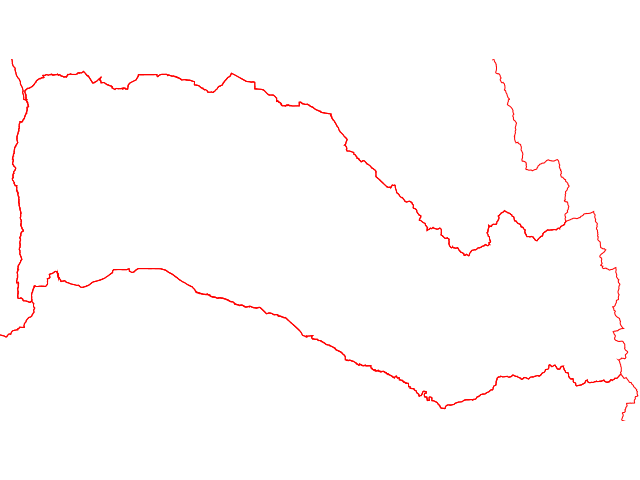

In [41]:
##print basins in grass @ Regional scale to confirm data and extent
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem+'_b')
gs.run_command('d.vect', map= basins,color='red',fill_color='None')
Image(filename="map.png")

In [16]:
export=True
fn = 'accum_Snake_River_South_FP'
if export:
    gs.run_command('r.out.gdal', input= fn, output= raster_dir/f'{fn}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File
</home/data/Rasters/cassia_minidoka/accum_Snake_River_South_FP.tif>
created.


# END